In [ ]:
# #挂载到你的drive
# from google import colab
# colab.drive.mount('/content/drive')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rank_bm25

In [ ]:
!pip install sentence-transformers faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 42.7 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

# 加载 embedding 模型
EMBEDDING_MODEL = SentenceTransformer('all-MiniLM-L6-v2')
print("Embedding model loaded.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding model loaded.


In [ ]:
#DeepSeek Basic Information
DEEPSEEK_API_URL = "https://api.deepseek.com"
DEEPSEEK_MODEL = "deepseek-chat"
# DEEPSEEK_API_KEY = 'sk-3f286f5841e545039ea8647dd16f171d'#change to your key~~~~用我的也行
DEEPSEEK_API_KEY ='sk-24a81c28b20f4511ae283263d5d528e5'
headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer sk-3f286f5841e545039ea8647dd16f171d"
}

In [ ]:
# BM25,FAISS,分数融合,RRF融合
def _normalize_scores(scores):
    """
    将分数列表归一化到 [0, 1] 区间
    """
    min_score = min(scores)
    max_score = max(scores)
    if max_score == min_score:
        # 如果所有分数都一样，则全部设为 0 或 1 (这里设为0)
        return [0.0] * len(scores)
    return [(s - min_score) / (max_score - min_score) for s in scores]

def _get_bm25_scores(question, sent_texts, sent_meta):
    """
    辅助函数：返回所有句子的 BM25 分数
    返回: { (title, sent_id) : score } 字典
    """
    if not sent_texts:
        return {}
    tokenized = [st.lower().split() for st in sent_texts]
    bm25 = BM25Okapi(tokenized)
    scores = bm25.get_scores(question.lower().split())

    return {meta: score for meta, score in zip(sent_meta, scores)}

def _get_faiss_scores(question, sent_texts, sent_meta):
    """
    辅助函数：返回所有句子的 FAISS 分数 (余弦相似度)
    返回: { (title, sent_id) : score } 字典
    """
    if not sent_texts:
        return {}

    # 1. 编码
    corpus_embeddings = EMBEDDING_MODEL.encode(sent_texts, convert_to_numpy=True)
    question_embedding = EMBEDDING_MODEL.encode(question, convert_to_numpy=True)

    # 2. 归一化向量 (L2 norm)，这样内积(IP)就等于余弦相似度
    faiss.normalize_L2(corpus_embeddings)
    question_embedding_np = np.array([question_embedding], dtype='float32')
    faiss.normalize_L2(question_embedding_np)

    # 3. 构建 IndexFlatIP (内积) 索引
    d = corpus_embeddings.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(corpus_embeddings.astype('float32'))

    # 4. 搜索所有文档 (k=len(sent_texts))
    # D 是相似度 (内积)，I 是索引
    similarities, indices = index.search(question_embedding_np, k=len(sent_texts))

    # 5. 构建分数字典
    scores_dict = {}
    for i, sim in zip(indices[0], similarities[0]):
        if i != -1: # -1 是 faiss 中的无效索引
            scores_dict[sent_meta[i]] = sim
    return scores_dict

def retrieve_topk_sents_faiss_only(question, context, k=6):
    """
    仅使用 FAISS (稠密/向量) 进行检索
    """
    # 1. 构建句子语料库 (复用你已有的函数)
    sent_texts, sent_meta = build_per_example_corpus(context)
    if not sent_texts:
        return [], []

    # 2. 将句子和问题编码为向量
    try:
        corpus_embeddings = EMBEDDING_MODEL.encode(sent_texts, convert_to_numpy=True)
        question_embedding = EMBEDDING_MODEL.encode(question, convert_to_numpy=True)
    except Exception as e:
        print(f"Error encoding texts: {e}")
        return [], []

    # 3. 构建 FAISS 索引 (使用余弦相似度)

    # 归一化向量 (L2 norm)，这样内积(IP)就等于余弦相似度
    corpus_embeddings_norm = corpus_embeddings.astype('float32')
    faiss.normalize_L2(corpus_embeddings_norm)

    question_embedding_norm = np.array([question_embedding], dtype='float32')
    faiss.normalize_L2(question_embedding_norm)

    # 3. 构建 IndexFlatIP (内积) 索引
    d = corpus_embeddings_norm.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(corpus_embeddings_norm)

    # 4. 搜索
    # D 是相似度 (内积)，I 是索引
    # 我们搜索 k 个最近邻
    similarities, indices = index.search(question_embedding_norm, k)

    # 5. 整理并返回结果
    top_idx = indices[0]

    # 过滤掉可能的 -1 (如果k大于索引中的向量数)
    top_idx = [i for i in top_idx if i != -1]

    retrieved = [sent_texts[i] for i in top_idx]
    meta = [sent_meta[i] for i in top_idx]

    return retrieved, meta

def retrieve_topk_sents_hybrid_fusion(question, context, k=6, alpha=0.6):
    """
    混合搜索：BM25 和 FAISS 分数融合
    alpha: BM25 的权重 (0.0 to 1.0)
    """
    # 1. 构建语料库
    sent_texts, sent_meta = build_per_example_corpus(context)
    if not sent_texts:
        return [], []

    # 2. 获取两边的分数
    bm25_scores_dict = _get_bm25_scores(question, sent_texts, sent_meta)
    faiss_scores_dict = _get_faiss_scores(question, sent_texts, sent_meta)

    # 3. 归一化
    # 确保我们按 sent_meta 的原始顺序来归一化
    bm25_scores_list = [bm25_scores_dict.get(meta, 0.0) for meta in sent_meta]
    faiss_scores_list = [faiss_scores_dict.get(meta, 0.0) for meta in sent_meta]

    norm_bm25_scores = _normalize_scores(bm25_scores_list)
    norm_faiss_scores = _normalize_scores(faiss_scores_list)

    # 4. 融合
    fused_scores = []
    for i, meta in enumerate(sent_meta):
        bm25_s = norm_bm25_scores[i]
        faiss_s = norm_faiss_scores[i]

        # 融合公式
        final_score = (alpha * bm25_s) + ((1 - alpha) * faiss_s)
        fused_scores.append((final_score, meta))

    # 5. 排序并取 Top-K
    fused_scores.sort(key=lambda x: x[0], reverse=True) # 按分数降序

    top_k_metas = [meta for score, meta in fused_scores[:k]]

    # 6. 整理并返回结果
    # 需要一个从 (title, sent_id) 到 文本 的映射
    meta_to_text = {meta: text for meta, text in zip(sent_meta, sent_texts)}

    retrieved = [meta_to_text[meta] for meta in top_k_metas]
    meta = top_k_metas

    return retrieved, meta

def retrieve_topk_sents_rrf(question, context, k=6, rrf_k=60):
    """
    混合搜索：BM25 和 FAISS RRF 融合
    k: 最终返回的 top-k 句子数量
    rrf_k: RRF 算法中的平滑常数 (通常是60)
    """
    # 1. 构建语料库
    sent_texts, sent_meta = build_per_example_corpus(context)
    if not sent_texts:
        return [], []

    # 2. 获取两边的分数 (需要 _get_bm25_scores 和 _get_faiss_scores 已定义)
    try:
        bm25_scores_dict = _get_bm25_scores(question, sent_texts, sent_meta)
        faiss_scores_dict = _get_faiss_scores(question, sent_texts, sent_meta)
    except NameError:
        print("错误：请确保 _get_bm25_scores 和 _get_faiss_scores 函数已定义。")
        return [], []

    # 3. 将分数字典转换为排名列表
    # BM25: 按分数降序排序
    bm25_ranked_list = sorted(
        bm25_scores_dict.items(),
        key=lambda item: item[1],
        reverse=True
    )
    # FAISS: 按分数(相似度)降序排序
    faiss_ranked_list = sorted(
        faiss_scores_dict.items(),
        key=lambda item: item[1],
        reverse=True
    )

    # 4. 计算 RRF 分数
    rrf_scores = {}

    # 遍历 BM25 排名
    for rank, (meta, score) in enumerate(bm25_ranked_list):
        # rank 从 0 开始, 所以 RRF 的 rank 是 (rank + 1)
        rrf_rank = rank + 1
        rrf_score = 1.0 / (rrf_k + rrf_rank)

        if meta not in rrf_scores:
            rrf_scores[meta] = 0.0
        rrf_scores[meta] += rrf_score

    # 遍历 FAISS 排名
    for rank, (meta, score) in enumerate(faiss_ranked_list):
        rrf_rank = rank + 1
        rrf_score = 1.0 / (rrf_k + rrf_rank)

        if meta not in rrf_scores:
            rrf_scores[meta] = 0.0
        rrf_scores[meta] += rrf_score

    # 5. 按 RRF 综合得分排序
    sorted_rrf = sorted(
        rrf_scores.items(),
        key=lambda item: item[1],
        reverse=True
    )

    # 6. 取 Top-K
    top_k_metas = [meta for meta, score in sorted_rrf[:k]]

    # 7. 整理并返回结果
    meta_to_text = {meta: text for meta, text in zip(sent_meta, sent_texts)}

    retrieved = [meta_to_text[meta] for meta in top_k_metas]
    meta = top_k_metas

    return retrieved, meta

In [ ]:
# import pandas as pd
# import os
# from tqdm.auto import tqdm
# import json
# import numpy as np

# # --- 确保辅助函数 _coerce_gold_sf 存在 ---
# # (这个函数在您新 notebook 的 Cell 7 中已经定义了，
# # 请确保您在运行此单元之前，已经运行了包含 _coerce_gold_sf 的单元)
# #
# # def _coerce_gold_sf(x):
# #     ... (代码来自您 notebook 的 Cell 7)

# # --- 定义要测试的检索策略 ---
# # 字典的键是策略名称，值是对应的检索函数
# # (这些函数需要您在 Cell 6 中已经定义并执行)
# retrieval_strategies = {
#     "faiss_only": lambda q, ctx, k_val: retrieve_topk_sents_faiss_only(q, ctx, k=k_val),
#     "hybrid_fusion_alpha_0.6": lambda q, ctx, k_val: retrieve_topk_sents_hybrid_fusion(q, ctx, k=k_val, alpha=0.6),
#     "rrf_k_60": lambda q, ctx, k_val: retrieve_topk_sents_rrf(q, ctx, k=k_val, rrf_k=60)
# }

# # --- K 值范围 ---
# k_range = range(6, 16) # 6 到 15 (包含15)

# # --- 存储所有结果 ---
# all_results = []

# # --- 遍历样本 (subset 变量来自您 notebook 的 Cell 7) ---
# # 注意：您的 subset 大小为 1000，这将运行 1000 * 3 * 10 = 30,000 次检索
# for i_sample, ex in enumerate(tqdm(subset, desc="Processing Samples for Retrieval Eval")):
#     q = ex["question"]
#     context = ex["context"]

#     # 1. 获取标准答案 (Supporting Facts)
#     # 使用您在 Cell 7 中定义的 _coerce_gold_sf 函数
#     gold_sf_raw = ex.get("supporting_facts", [])
#     gold_sf_pairs = _coerce_gold_sf(gold_sf_raw)
#     gold_sf_set = set(gold_sf_pairs)
#     num_gold_sf = len(gold_sf_set)

#     if num_gold_sf == 0:
#         continue # 没有标准答案的样本无法评估

#     # 2. 遍历每种检索策略
#     for strategy_name, strategy_func in retrieval_strategies.items():

#         # 3. 遍历 K 值
#         for k_val in k_range:

#             # 执行检索
#             try:
#                 retrieved_sents, retrieved_meta_pairs = strategy_func(q, context, k_val)
#             except Exception as e:
#                 print(f"Error during retrieval for sample {i_sample}, strategy {strategy_name}: {e}")
#                 continue

#             # 转换检索结果为 (title, sent_id) 的集合
#             retrieved_sf_set = set()
#             for t, sid in retrieved_meta_pairs:
#                 try:
#                     retrieved_sf_set.add((str(t).strip(), int(sid)))
#                 except (ValueError, TypeError):
#                     continue

#             num_retrieved_sf = len(retrieved_sf_set)

#             # 4. 计算指标
#             correct_matches = len(gold_sf_set.intersection(retrieved_sf_set))

#             precision = correct_matches / num_retrieved_sf if num_retrieved_sf > 0 else 0.0
#             recall = correct_matches / num_gold_sf # num_gold_sf 已检查不为0
#             f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

#             # 5. 存储结果
#             all_results.append({
#                 "sample_index": i_sample,
#                 "strategy": strategy_name,
#                 "top_k": k_val,
#                 "num_gold_sf": num_gold_sf,
#                 "num_retrieved_sf": num_retrieved_sf,
#                 "correct_matches": correct_matches,
#                 "recall": recall,
#                 "precision": precision,
#                 "f1": f1
#             })

#             # 优化：如果召回率已达100%，没必要测试更大的 K 值
#             if recall == 1.0:
#                 break # 中断 k_range 循环

# # --- 整理并保存结果 ---
# results_df = pd.DataFrame(all_results)

# # 定义保存路径 (这里假设您想保存在 Colab 根目录)
# output_filename = "rag_fusion_retrieval_metrics.csv"
# results_df.to_csv(output_filename, index=False)

# print(f"\n详细检索评估结果已保存到: {output_filename}")

# # --- 计算并显示聚合表格 ---
# print("\n--- 聚合性能指标 (按策略和 K 值) ---")

# # 按 strategy 和 top_k 聚合，计算 recall, precision, f1 的平均值
# agg_df = results_df.groupby(['strategy', 'top_k'])[['recall', 'precision', 'f1']].mean().reset_index()

# # 格式化输出，便于阅读
# agg_df['recall'] = agg_df['recall'].map('{:.4f}'.format)
# agg_df['precision'] = agg_df['precision'].map('{:.4f}'.format)
# agg_df['f1'] = agg_df['f1'].map('{:.4f}'.format)

# # 使用 to_markdown 打印表格
# print(agg_df.to_markdown(index=False))

# # (在 Colab/Jupyter 中，使用 display(agg_df) 会显示一个更漂亮的 HTML 表格)
# # display(agg_df)

In [ ]:
import random
import re
import string
import time
import json
import requests
from datasets import load_dataset
from datasets import concatenate_datasets
from rank_bm25 import BM25Okapi
from tqdm.auto import tqdm
from openai import OpenAI  # Import OpenAI again to be explicit
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed  # Import for multi-threading
from typing import List, Tuple, Iterable, Union

# 固定随机种子（可选）
random.seed(42)

# =========================
# 1) HotpotQA  共抽一万条，具体条数可以在total_samples 修改，demo可以不测那么多（测1000条足够）
# =========================
dataset = load_dataset("hotpot_qa", "distractor")  # 包含 train/dev/test

total_samples = 1000
ratio_sum = 1 + 3 + 1  # 1:3:1 分布
easy_samples = int(total_samples * (1 / ratio_sum))
medium_samples = int(total_samples * (3 / ratio_sum))
hard_samples = total_samples - easy_samples - medium_samples  # 补齐到 total_samples

train_dataset = dataset["train"]

easy_dataset = train_dataset.filter(lambda example: example["level"] == "easy")
medium_dataset = train_dataset.filter(lambda example: example["level"] == "medium")
hard_dataset = train_dataset.filter(lambda example: example["level"] == "hard")

# Sample with explicit seed for reproducibility
sampled_easy = easy_dataset.select(random.sample(range(len(easy_dataset)), min(len(easy_dataset), easy_samples)))
sampled_medium = medium_dataset.select(random.sample(range(len(medium_dataset)), min(len(medium_dataset), medium_samples)))
sampled_hard = hard_dataset.select(random.sample(range(len(hard_dataset)), min(len(hard_dataset), hard_samples)))

print(f"Sampled {len(sampled_easy)} easy examples.")
print(f"Sampled {len(sampled_medium)} medium examples.")
print(f"Sampled {len(sampled_hard)} hard examples.")

sampled_dataset = concatenate_datasets([sampled_easy, sampled_medium, sampled_hard])
print(f"Total sampled examples: {len(sampled_dataset)}")

# 为了后续按索引取元素，转成普通 list（Dataset 索引与 enumerate 一致）
subset = [sampled_dataset[i] for i in range(len(sampled_dataset))]

# =========================
# 2) RAG：对每条样本的候选“句子”做 BM25（纯 baseline）
# =========================
def split_sentences(text):
    parts = re.split(r'(?<=[.?!;。！？])\s+', text.strip())
    return [p.strip() for p in parts if p.strip()]

def _iter_titles_sents_from_context(context):
    """
    HotpotQA distractor 的 context 结构通常是：
      context: List[[title:str, sentences:List[str]], ...]
    也兼容另一种自定义 dict 结构：
      context: {'title': List[str], 'sentences': List[List[str]]}
    """
    # 形如 dict
    if isinstance(context, dict) and "title" in context and "sentences" in context:
        for t, sents in zip(context["title"], context["sentences"]):
            yield t, sents
        return
    # 形如 list of [title, sentences]
    if isinstance(context, list):
        for item in context:
            if isinstance(item, (list, tuple)) and len(item) == 2:
                t, sents = item[0], item[1]
                yield t, sents
        return
    # 兜底：不认识的结构，直接空
    return

def build_per_example_corpus(context):
    """
    return：sent_texts, sent_meta ；其中 meta = (title, sent_id)
    """
    sent_texts, sent_meta = [], []
    for title, sents in _iter_titles_sents_from_context(context):
        for i, s in enumerate(sents):
            s = (s or "").strip()
            if not s:
                continue
            sent_texts.append(s)
            sent_meta.append((title, i))
    return sent_texts, sent_meta

def retrieve_topk_sents(question, context, k=6):
    sent_texts, sent_meta = build_per_example_corpus(context)
    if not sent_texts:
        return [], []
    tokenized = [st.lower().split() for st in sent_texts]
    bm25 = BM25Okapi(tokenized)
    scores = bm25.get_scores(question.lower().split())
    top_idx = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:k]
    retrieved = [sent_texts[i] for i in top_idx]
    meta = [sent_meta[i] for i in top_idx]
    return retrieved, meta

# =========================
# 3) 规范化 & 评测（Answer EM/F1）
#   与 HotpotQA/ SQuAD 常用后处理一致：小写、去标点/冠词、压空白
# =========================
def normalize_text(s):
    def remove_articles(t):
        return re.sub(r"\b(a|an|the)\b", " ", t)
    def remove_punc(t):
        table = str.maketrans("", "", string.punctuation)
        return t.translate(table)
    def white_space_fix(t):
        return " ".join(t.split())
    return white_space_fix(remove_articles(remove_punc((s or "").lower())))

def f1_score(pred, truth):
    # token overlap F1
    p_tokens = normalize_text(pred).split()
    t_tokens = normalize_text(truth).split()
    if len(p_tokens) == 0 and len(t_tokens) == 0:
        return 1.0
    if len(p_tokens) == 0 or len(t_tokens) == 0:
        return 0.0
    # 计数要用频次
    from collections import Counter
    pc, tc = Counter(p_tokens), Counter(t_tokens)
    num_same = sum((pc & tc).values())
    if num_same == 0:
        return 0.0
    precision = num_same / len(p_tokens)
    recall    = num_same / len(t_tokens)
    return 2 * precision * recall / (precision + recall)

def exact_match_score(pred, truth):
    return 1 if normalize_text(pred) == normalize_text(truth) else 0

def evaluate_answers(golds, preds, return_per_item=False):
    ems, f1s = [], []
    for g, p in zip(golds, preds):
        ems.append(exact_match_score(p, g))
        f1s.append(f1_score(p, g))
    em = sum(ems)/len(ems) if ems else 0.0
    f1 = sum(f1s)/len(f1s) if f1s else 0.0
    if return_per_item:
        return em, f1, ems, f1s
    else:
        return em, f1

def evaluate_supporting_facts(
    golds_sf: List[Iterable[Union[Tuple[str, int], List[Union[str, int]]]]],
    preds_sf: List[Iterable[Union[Tuple[str, int], List[Union[str, int]]]]],
    return_per_item: bool = False,
):
    """
    支撑事实（Supporting Facts）集合级 EM 与 F1
    """
    assert len(golds_sf) == len(preds_sf), "golds_sf 与 preds_sf 长度需一致"

    def _norm_title(t: str) -> str:
        return " ".join((t or "").strip().split()).lower()

    def _to_set(items) -> "set[tuple[str, int]]":
        s = set()
        if items is None:
            return s
        for it in items:
            if isinstance(it, (tuple, list)) and len(it) >= 2:
                title, sid = it[0], it[1]
                try:
                    sid = int(sid)
                except Exception:
                    continue
                s.add((_norm_title(str(title)), sid))
        return s

    em_list, f1_list = [], []
    for g, p in zip(golds_sf, preds_sf):
        g_set = _to_set(g)
        p_set = _to_set(p)
        em = 1.0 if p_set == g_set else 0.0
        em_list.append(em)

        if not g_set and not p_set:
            f1 = 1.0
        elif not g_set or not p_set:
            f1 = 0.0
        else:
            inter = len(g_set & p_set)
            prec = inter / len(p_set) if len(p_set) > 0 else 0.0
            rec  = inter / len(g_set) if len(g_set) > 0 else 0.0
            f1 = 0.0 if (prec + rec) == 0 else 2 * prec * rec / (prec + rec)
        f1_list.append(f1)

    sf_em = sum(em_list)/len(em_list) if em_list else 0.0
    sf_f1 = sum(f1_list)/len(f1_list) if f1_list else 0.0

    if return_per_item:
        return sf_em, sf_f1, em_list, f1_list
    else:
        return sf_em, sf_f1

# =========================
# 4) Prompt 及 API 调用
# =========================
SYSTEM_PROMPT = (
    "You are a precise QA assistant. Use ONLY the given context sentences. "
    "Return a short span or 'yes'/'no'. Also return the supporting facts you used "
    "as (title, sent_id) pairs. If evidence is insufficient, answer 'insufficient evidence'. "
    "Output MUST be a single JSON object with keys: answer, supporting_facts."
)

def build_prompt(question, retrieved_sents, retrieved_meta):
    """
    retrieved_sents: List[str]
    retrieved_meta:  List[{'title': str, 'sent_id': int}]  # 与每条句子一一对应
    """
    lines = []
    for i, (sent, meta) in enumerate(zip(retrieved_sents, retrieved_meta), 1):
        lines.append(f"- [{i}] [Title={meta['title']}] [SentId={meta['sent_id']}] {sent}")
    ctx = "\n".join(lines)

    user = f"""Context sentences (each line has an index and metadata):
{ctx}

Question: {question}

Return STRICTLY this JSON schema:
{{
  "answer": "<one short span or yes/no or 'insufficient evidence'>",
  "supporting_facts": [{{"title": "<string>", "sent_id": <int>}}, ...]
}}"""
    return [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": user},
    ]

def call_deepseek(messages, max_tokens=64, temperature=0.2, retries=3, timeout=60):
    client = OpenAI(
        api_key=DEEPSEEK_API_KEY,
        base_url=DEEPSEEK_API_URL
    )
    for attempt in range(retries):
        try:
            response = client.chat.completions.create(
                model=DEEPSEEK_MODEL,
                messages=messages,
                temperature=temperature,
                max_tokens=max_tokens,
                stream=False,
                timeout=timeout
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            time.sleep(1.5 * (attempt + 1))
    return ""

# =========================
# 5) 主循环：检索 -> 生成 -> 评测
#    （评测 Answer EM/F1、Supporting Facts EM/F1、Joint）
# =========================

def _coerce_gold_sf(x):
    """把 HotpotQA supporting_facts 转成 (title, sent_id) 列表，忽略多余字段。"""
    out = []
    # Handle dictionary format {'title': [...], 'sent_id': [...]}
    if isinstance(x, dict) and "title" in x and "sent_id" in x:
        titles = x.get("title", [])
        sent_ids = x.get("sent_id", [])
        # Ensure both lists have the same length and iterate
        for title, sid_raw in zip(titles, sent_ids):
             try:
                sid = int(sid_raw)
                out.append((str(title).strip(), sid))
             except (ValueError, TypeError):
                continue # Skip if sent_id is not a valid integer
    # Handle list of lists/tuples format (original logic)
    elif isinstance(x, list):
        for it in (x or []):
            if isinstance(it, (list, tuple)) and len(it) >= 2:
                title, sid_raw = it[0], it[1]
                try:
                    sid = int(sid_raw)
                    out.append((str(title).strip(), sid))
                except (ValueError, TypeError):
                    continue # Skip if sent_id is not a valid integer
    return out



README.md: 0.00B [00:00, ?B/s]

distractor/train-00000-of-00002.parquet:   0%|          | 0.00/166M [00:00<?, ?B/s]

distractor/train-00001-of-00002.parquet:   0%|          | 0.00/166M [00:00<?, ?B/s]

distractor/validation-00000-of-00001.par(…):   0%|          | 0.00/27.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/90447 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7405 [00:00<?, ? examples/s]

Filter:   0%|          | 0/90447 [00:00<?, ? examples/s]

Filter:   0%|          | 0/90447 [00:00<?, ? examples/s]

Filter:   0%|          | 0/90447 [00:00<?, ? examples/s]

Sampled 200 easy examples.
Sampled 600 medium examples.
Sampled 200 hard examples.
Total sampled examples: 1000


In [ ]:
def _get_gold_sf_pairs(gold_sf_dict):
    """
    辅助函数：将 HotpotQA 的 gold_sf 字段（可能是 dict 或 list）
    统一转换为 (title, sent_id) 元组的列表。
    """
    pairs = set()
    if isinstance(gold_sf_dict, dict) and "title" in gold_sf_dict and "sent_id" in gold_sf_dict:
        titles = gold_sf_dict.get("title", [])
        sent_ids = gold_sf_dict.get("sent_id", [])
        for title, sid_raw in zip(titles, sent_ids):
            try:
                sid = int(sid_raw)
                pairs.add((str(title).strip(), sid))
            except (ValueError, TypeError):
                continue
    elif isinstance(gold_sf_dict, list):
         for it in gold_sf_dict:
            if isinstance(it, (list, tuple)) and len(it) >= 2:
                title, sid_raw = it[0], it[1]
                try:
                    sid = int(sid_raw)
                    pairs.add((str(title).strip(), sid))
                except (ValueError, TypeError):
                    continue
    return list(pairs)

def process_sample(i_sample, ex):
    """
    处理单个样本的函数，用于并行化。
    它会返回一个包含该样本所有评测结果的列表。
    """
    q = ex["question"]
    context = ex["context"]
    gold_sf_raw = ex.get("supporting_facts", [])

    # 1. 规范化黄金支撑事实 (Gold SF)
    gold_sf_pairs = _get_gold_sf_pairs(gold_sf_raw)
    num_gold_sf = len(gold_sf_pairs)

    if num_gold_sf == 0:
        return [] # 如果没有黄金SF，返回空列表

    gold_sf_set = set(gold_sf_pairs)
    sample_results = [] # 存储这个样本的所有结果

    # 2. 循环测试三种检索方法
    for method_name, method_func in retrieval_methods.items():

        all_sfs_found = False

        # 3. 循环测试不同的 Top K 值
        for topK in range(6, 21):

            if all_sfs_found:
                # 优化：如果K=N时已召回所有，K=N+1时不必再测
                break

            # 4. 调用对应的检索函数
            retrieved_sents = []
            retrieved_meta_pairs = []

            try:
                if method_name == "ScoreFusion_Hybrid":
                    retrieved_sents, retrieved_meta_pairs = method_func(
                        q, context, k=topK, alpha=0.6 # 默认 alpha=0.5
                    )
                else:
                    retrieved_sents, retrieved_meta_pairs = method_func(
                        q, context, k=topK
                    )
            except Exception as e:
                # 打印错误但继续执行，避免一个样本失败导致整个评测中断
                print(f"Error in thread for sample {i_sample}, method {method_name}: {e}")
                continue

            # 5. 规范化检索到的支撑事实 (Retrieved SF)
            retrieved_sf_pairs = [
                (str(t).strip(), int(sid))
                for t, sid in retrieved_meta_pairs
                if isinstance(sid, (int, np.integer))
            ]
            num_retrieved_sf = len(retrieved_sf_pairs)
            retrieved_sf_set = set(retrieved_sf_pairs)

            # 6. 计算指标
            correct_matches = len(gold_sf_set.intersection(retrieved_sf_set))

            precision = correct_matches / num_retrieved_sf if num_retrieved_sf > 0 else 0.0
            recall = correct_matches / num_gold_sf if num_gold_sf > 0 else 0.0
            f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

            # 7. 存储结果
            sample_results.append({
                "sample_index": i_sample,
                "method": method_name,
                "top_k": topK,
                "num_gold_sf": num_gold_sf,
                "num_retrieved_sf": num_retrieved_sf,
                "correct_matches": correct_matches,
                "recall": recall,
                "precision": precision,
                "f1": f1
            })

            # 8. 检查是否可以提前终止K值循环
            if correct_matches == num_gold_sf:
                all_sfs_found = True

    return sample_results # 返回此样本的所有结果

In [ ]:
import pandas as pd
import os
from tqdm.auto import tqdm
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed

# --- 检索评测 (Retrieval Evaluation) - 仅 K=3 到 5 ---
# 目标：并行评测 BM25、FAISS 和 ScoreFusion 在 K 值 3, 4, 5 时的性能
# 并将结果保存到 *新* 的临时文件中

# 定义输出目录
# (确保此路径与你之前单元格中的 output_dir 一致)
output_dir = "/content/drive/MyDrive/hotpot/Results"
os.makedirs(output_dir, exist_ok=True)

# 定义 *新* 的输出文件名，用于 K=3-5 的结果
detailed_output_k3_5 = os.path.join(output_dir, "fusion_retrieval_metrics_B_F_S_k3-5.csv")
aggregated_output_k3_5 = os.path.join(output_dir, "aggregated_fusion_retrieval_metrics_B_F_S_k3-5.csv")

# 存储所有样本在所有K值下的结果
all_results_k3_5 = []

# 引用之前单元格中定义的检索函数
retrieval_methods = {
    "BM25_Only": retrieve_topk_sents,
    "FAISS_Only": retrieve_topk_sents_faiss_only,
    "ScoreFusion_Hybrid": retrieve_topk_sents_hybrid_fusion
}

# 引用之前单元格中定义的辅助函数
# def _get_gold_sf_pairs(gold_sf_dict): ...
# def process_sample(i_sample, ex): ... (但我们需要修改它)

def process_sample_k3_5(i_sample, ex):
    """
    处理单个样本的函数 (K=3-5 版本)。
    """
    q = ex["question"]
    context = ex["context"]
    gold_sf_raw = ex.get("supporting_facts", [])

    gold_sf_pairs = _get_gold_sf_pairs(gold_sf_raw)
    num_gold_sf = len(gold_sf_pairs)

    if num_gold_sf == 0:
        return []

    gold_sf_set = set(gold_sf_pairs)
    sample_results = []

    for method_name, method_func in retrieval_methods.items():
        all_sfs_found = False

        # --- 关键修改：仅测试 K=3, 4, 5 ---
        for topK in range(3, 6): # range(3, 6) 会生成 3, 4, 5
            if all_sfs_found:
                break

            retrieved_sents = []
            retrieved_meta_pairs = []

            try:
                if method_name == "ScoreFusion_Hybrid":
                    retrieved_sents, retrieved_meta_pairs = method_func(
                        q, context, k=topK, alpha=0.6
                    )
                else:
                    retrieved_sents, retrieved_meta_pairs = method_func(
                        q, context, k=topK
                    )
            except Exception as e:
                print(f"Error in thread for sample {i_sample}, method {method_name}: {e}")
                continue

            retrieved_sf_pairs = [
                (str(t).strip(), int(sid))
                for t, sid in retrieved_meta_pairs
                if isinstance(sid, (int, np.integer))
            ]
            num_retrieved_sf = len(retrieved_sf_pairs)
            retrieved_sf_set = set(retrieved_sf_pairs)

            correct_matches = len(gold_sf_set.intersection(retrieved_sf_set))

            precision = correct_matches / num_retrieved_sf if num_retrieved_sf > 0 else 0.0
            recall = correct_matches / num_gold_sf if num_gold_sf > 0 else 0.0
            f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

            sample_results.append({
                "sample_index": i_sample,
                "method": method_name,
                "top_k": topK,
                "num_gold_sf": num_gold_sf,
                "num_retrieved_sf": num_retrieved_sf,
                "correct_matches": correct_matches,
                "recall": recall,
                "precision": precision,
                "f1": f1
            })

            if correct_matches == num_gold_sf:
                all_sfs_found = True

    return sample_results

# --- 主循环 (并行版, K=3-5) ---
# (确保 'subset' 变量已在之前单元格定义)
with ThreadPoolExecutor(max_workers=20) as executor:
    futures = {}
    for i_sample, ex in enumerate(subset):
        future = executor.submit(process_sample_k3_5, i_sample, ex)
        futures[future] = i_sample

    for future in tqdm(as_completed(futures), total=len(subset), desc="Processing Samples (Parallel, K=3-5)"):
        try:
            sample_results_list = future.result()
            all_results_k3_5.extend(sample_results_list)
        except Exception as e:
            sample_index = futures[future]
            print(f"Sample {sample_index} generated an exception: {e}")

# --- 保存 K=3-5 的结果到 *新* 文件 ---
print(f"\nCollected {len(all_results_k3_5)} total metric entries for K=3-5.")

# 1. 保存详细结果 (k=3-5)
results_df_k3_5 = pd.DataFrame(all_results_k3_5)
if not results_df_k3_5.empty:
    results_df_k3_5 = results_df_k3_5.sort_values(by=["method", "sample_index", "top_k"]).reset_index(drop=True)
results_df_k3_5.to_csv(detailed_output_k3_5, index=False)
print(f"Detailed retrieval metrics (K=3-5) saved to: {detailed_output_k3_5}")

# 2. 保存聚合结果 (k=3-5)
if not results_df_k3_5.empty:
    aggregated_metrics_k3_5 = results_df_k3_5.groupby(['method', 'top_k'])[['recall', 'precision', 'f1']].mean()
    aggregated_metrics_k3_5.to_csv(aggregated_output_k3_5, index=True)
    print(f"Aggregated retrieval metrics (K=3-5) saved to: {aggregated_output_k3_5}")
    display(aggregated_metrics_k3_5)
else:
    print("No results were generated for K=3-5.")

Processing Samples (Parallel, K=3-5):   0%|          | 0/1000 [00:00<?, ?it/s]


Collected 7672 total metric entries for K=3-5.
Detailed retrieval metrics (K=3-5) saved to: /content/drive/MyDrive/hotpot/Results/fusion_retrieval_metrics_B_F_S_k3-5.csv
Aggregated retrieval metrics (K=3-5) saved to: /content/drive/MyDrive/hotpot/Results/aggregated_fusion_retrieval_metrics_B_F_S_k3-5.csv


recall  precision        f1
method             top_k                               
BM25_Only          3      0.484633   0.373333  0.415851
                   4      0.447498   0.274818  0.334850
                   5      0.460690   0.230091  0.301730
FAISS_Only         3      0.485467   0.372333  0.415686
                   4      0.430842   0.263174  0.321328
                   5      0.451830   0.224314  0.294891
ScoreFusion_Hybrid 3      0.539550   0.416333  0.463432
                   4      0.480858   0.299616  0.362939
                   5      0.493502   0.250210  0.326435

In [ ]:
import pandas as pd
import os

# --- 合并 K=3-5 和 K=6-20 的评测结果 ---

# 确保输出目录与之前一致
output_dir = "/content/drive/MyDrive/hotpot/Results"

# 1. 定义文件路径
# 原始 (k=6-20) 文件
orig_detailed_file = os.path.join(output_dir, "fusion_retrieval_metrics_B_F_S.csv")
orig_agg_file = os.path.join(output_dir, "aggregated_fusion_retrieval_metrics_B_F_S.csv")

# 新的 (k=3-5) 文件
new_detailed_file = os.path.join(output_dir, "fusion_retrieval_metrics_B_F_S_k3-5.csv")
new_agg_file = os.path.join(output_dir, "aggregated_fusion_retrieval_metrics_B_F_S_k3-5.csv")

# 最终（k=3-20）文件
orig_detailed_file1 = os.path.join(output_dir, "r_fusion_retrieval_metrics_B_F_S.csv")
orig_agg_file1 = os.path.join(output_dir, "r_aggregated_fusion_retrieval_metrics_B_F_S.csv")

print("--- Merging Detailed Results (fusion_retrieval_metrics_B_F_S.csv) ---")
try:
    # 2. 合并详细结果 (Detailed)
    df_orig_det = pd.read_csv(orig_detailed_file)
    df_new_det = pd.read_csv(new_detailed_file)

    df_combined_det = pd.concat([df_new_det, df_orig_det])
    df_combined_det = df_combined_det.sort_values(by=["method", "sample_index", "top_k"]).reset_index(drop=True)

    # 3. 覆盖保存回原始文件
    df_combined_det.to_csv(orig_detailed_file1, index=False)
    print(f"SUCCESS: Merged detailed file (k=3-20) saved to: {orig_detailed_file1}")

except FileNotFoundError as e:
    print(f"ERROR: Could not merge detailed files. File not found: {e.filename}")
except Exception as e:
    print(f"An error occurred during detailed merge: {e}")


print("\n--- Merging Aggregated Results (aggregated_fusion_retrieval_metrics_B_F_S.csv) ---")
try:
    # 4. 合并聚合结果 (Aggregated)
    df_orig_agg = pd.read_csv(orig_agg_file)
    df_new_agg = pd.read_csv(new_agg_file)

    df_combined_agg = pd.concat([df_new_agg, df_orig_agg])
    df_combined_agg = df_combined_agg.sort_values(by=["method", "top_k"]).reset_index(drop=True)

    # 5. 覆盖保存回原始文件
    df_combined_agg.to_csv(orig_agg_file1, index=False)
    print(f"SUCCESS: Merged aggregated file (k=3-20) saved to: {orig_agg_file1}")

    print("\nDisplaying new combined aggregated metrics (head):")
    display(df_combined_agg.head(10)) # 显示合并后的头部 (应包含 k=3, 4, 5)

except FileNotFoundError as e:
    print(f"ERROR: Could not merge aggregated files. File not found: {e.filename}")
except Exception as e:
    print(f"An error occurred during aggregated merge: {e}")

--- Merging Detailed Results (fusion_retrieval_metrics_B_F_S.csv) ---
SUCCESS: Merged detailed file (k=3-20) saved to: /content/drive/MyDrive/hotpot/Results/r_fusion_retrieval_metrics_B_F_S.csv

--- Merging Aggregated Results (aggregated_fusion_retrieval_metrics_B_F_S.csv) ---
SUCCESS: Merged aggregated file (k=3-20) saved to: /content/drive/MyDrive/hotpot/Results/r_aggregated_fusion_retrieval_metrics_B_F_S.csv

Displaying new combined aggregated metrics (head):


,method,top_k,recall,precision,f1
0,BM25_Only,3,0.484633,0.373333,0.415851
1,BM25_Only,4,0.447498,0.274818,0.334850
2,BM25_Only,5,0.460690,0.230091,0.301730
3,BM25_Only,6,0.621375,0.241633,0.343417
4,BM25_Only,7,0.491457,0.179683,0.258861
5,BM25_Only,8,0.481440,0.156600,0.232568
6,BM25_Only,9,0.498018,0.145729,0.222116
7,BM25_Only,10,0.496840,0.130948,0.204247
8,BM25_Only,11,0.513702,0.123255,0.196023
9,BM25_Only,12,0.518792,0.115870,0.186846


--- 聚合结果 (表格形式, k=3-20) ---

--- 结果: BM25_Only ---


,recall,precision,f1
top_k,,,
3,0.484633,0.373333,0.415851
4,0.447498,0.274818,0.334850
5,0.460690,0.230091,0.301730
6,0.621375,0.241633,0.343417
7,0.491457,0.179683,0.258861
8,0.481440,0.156600,0.232568
9,0.498018,0.145729,0.222116
10,0.496840,0.130948,0.204247
11,0.513702,0.123255,0.196023



--- 结果: FAISS_Only ---


,recall,precision,f1
top_k,,,
3,0.485467,0.372333,0.415686
4,0.430842,0.263174,0.321328
5,0.451830,0.224314,0.294891
6,0.615592,0.238300,0.339298
7,0.468880,0.171689,0.247338
8,0.464338,0.152369,0.225829
9,0.479638,0.139460,0.212898
10,0.496518,0.130109,0.203223
11,0.509247,0.122576,0.194793



--- 结果: ScoreFusion_Hybrid ---


,recall,precision,f1
top_k,,,
3,0.539550,0.416333,0.463432
4,0.480858,0.299616,0.362939
5,0.493502,0.250210,0.326435
6,0.674358,0.261800,0.372388
7,0.507818,0.190635,0.272711
8,0.511847,0.169369,0.250483
9,0.526250,0.155983,0.236921
10,0.531246,0.144148,0.223389
11,0.545230,0.135480,0.213813



--- 聚合结果 (折线图) ---
F1 图像已保存到: /content/drive/MyDrive/hotpot/Results/retrieval_f1_vs_k.png


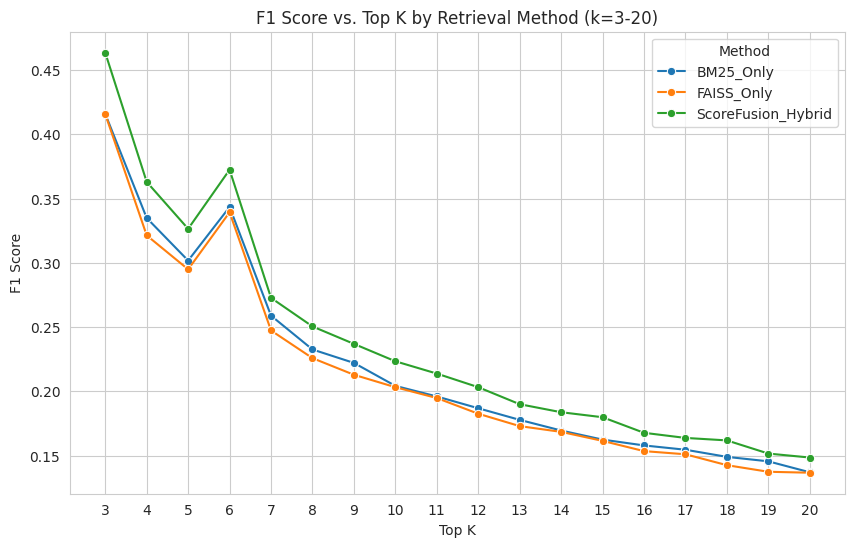

Recall 图像已保存到: /content/drive/MyDrive/hotpot/Results/retrieval_recall_vs_k.png


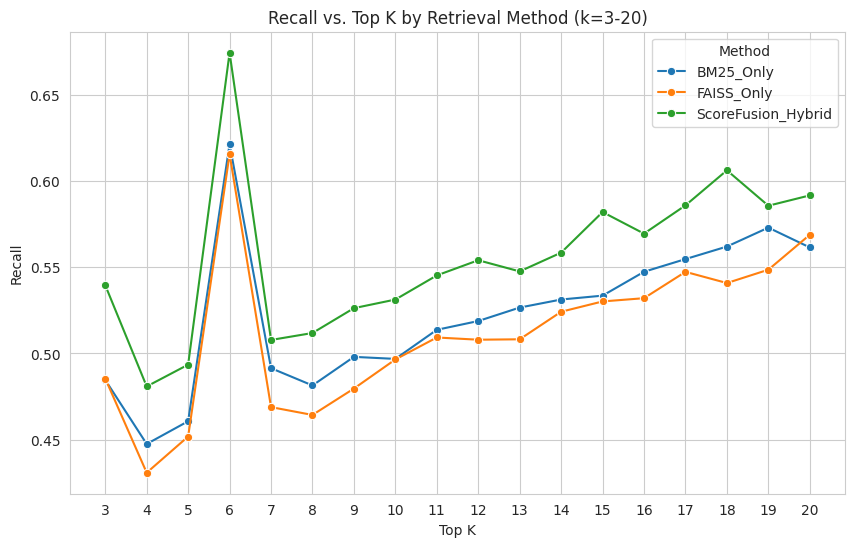

Precision 图像已保存到: /content/drive/MyDrive/hotpot/Results/retrieval_precision_vs_k.png


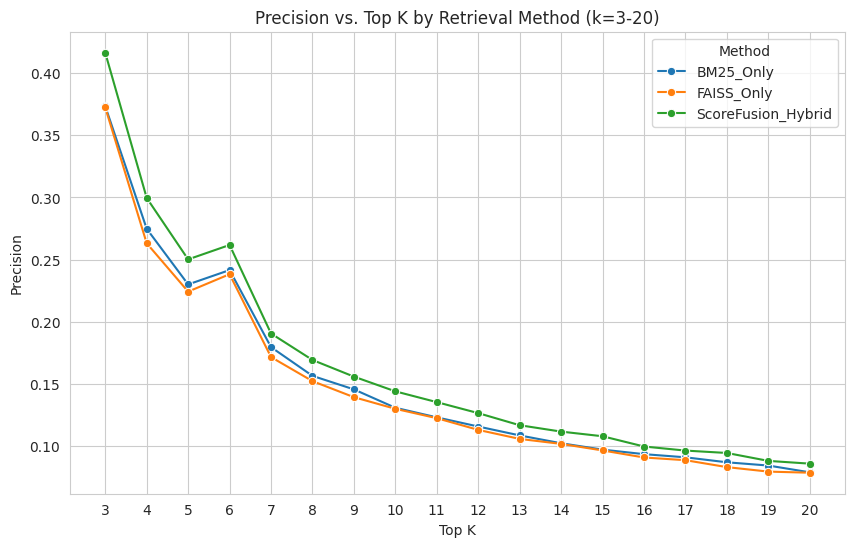


--- 可视化完成 ---


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- 单元格 3: 可视化最终合并的结果 ---

# 确保此路径与你之前单元格中的 output_dir 一致
# (!!!) 注意：根据你上一个请求，路径是 'hotpot/Results'
output_dir = "/content/drive/MyDrive/hotpot/Results"

# 这是上一个单元格合并后的最终聚合结果文件
aggregated_file_path = os.path.join(output_dir, "r_aggregated_fusion_retrieval_metrics_B_F_S.csv")

try:
    df_agg_merged = pd.read_csv(aggregated_file_path)
except FileNotFoundError:
    print(f"错误：找不到文件 {aggregated_file_path}")
    print("请确保你已经成功运行了上一个单元格（合并 CSV 文件）。")
    # 如果文件不存在，则停止执行此单元格
    raise
except Exception as e:
    print(f"读取文件时出错: {e}")
    raise

# --- 1. 参照你的图片，以表格形式分方法展示 ---
print("--- 聚合结果 (表格形式, k=3-20) ---")

# (确保 'method' 列存在)
if 'method' in df_agg_merged.columns:
    methods = df_agg_merged['method'].unique()
    # 确保显示顺序
    method_order = ['BM25_Only', 'FAISS_Only', 'ScoreFusion_Hybrid']

    for method in method_order:
        if method in methods:
            print(f"\n--- 结果: {method} ---")
            # 筛选出当前方法，并设置 top_k 为索引以便清晰显示
            df_method = df_agg_merged[df_agg_merged['method'] == method].set_index('top_k')
            # 仅显示三个关键指标
            display(df_method[['recall', 'precision', 'f1']])
else:
    print("数据中未找到 'method' 列，显示原始表格：")
    display(df_agg_merged)

# --- 2. 可视化 (折线图) ---
print("\n--- 聚合结果 (折线图) ---")

# 设置绘图风格
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['DejaVu Sans'] # 确保字体显示正常

# 图 1: F1 Score vs. Top K
plt.figure(figsize=(10, 6))
f1_plot = sns.lineplot(data=df_agg_merged, x='top_k', y='f1', hue='method', marker='o', hue_order=method_order)
f1_plot.set_title('F1 Score vs. Top K by Retrieval Method (k=3-20)')
f1_plot.set_xlabel('Top K')
f1_plot.set_ylabel('F1 Score')
plt.xticks(range(3, 21)) # 确保 X 轴刻度为 3 到 20 的整数
plt.legend(title='Method')
f1_fig_path = os.path.join(output_dir, "retrieval_f1_vs_k.png")
plt.savefig(f1_fig_path)
print(f"F1 图像已保存到: {f1_fig_path}")
plt.show() # 在 Colab 中显示图像

# 图 2: Recall vs. Top K
plt.figure(figsize=(10, 6))
recall_plot = sns.lineplot(data=df_agg_merged, x='top_k', y='recall', hue='method', marker='o', hue_order=method_order)
recall_plot.set_title('Recall vs. Top K by Retrieval Method (k=3-20)')
recall_plot.set_xlabel('Top K')
recall_plot.set_ylabel('Recall')
plt.xticks(range(3, 21))
plt.legend(title='Method')
recall_fig_path = os.path.join(output_dir, "retrieval_recall_vs_k.png")
plt.savefig(recall_fig_path)
print(f"Recall 图像已保存到: {recall_fig_path}")
plt.show()

# 图 3: Precision vs. Top K
plt.figure(figsize=(10, 6))
precision_plot = sns.lineplot(data=df_agg_merged, x='top_k', y='precision', hue='method', marker='o', hue_order=method_order)
precision_plot.set_title('Precision vs. Top K by Retrieval Method (k=3-20)')
precision_plot.set_xlabel('Top K')
precision_plot.set_ylabel('Precision')
plt.xticks(range(3, 21))
plt.legend(title='Method')
precision_fig_path = os.path.join(output_dir, "retrieval_precision_vs_k.png")
plt.savefig(precision_fig_path)
print(f"Precision 图像已保存到: {precision_fig_path}")
plt.show()

print("\n--- 可视化完成 ---")

In [ ]:
# pred_answers, gold_answers = [], []
# pred_sfs, gold_sfs = [], []   # 支撑事实 (title, sent_id) 列表
# results = {}
# TOPK = 30

# with ThreadPoolExecutor(max_workers=20) as executor:  # 可按需调整并发
#     futures = {}
#     for i, ex in enumerate(tqdm(subset, desc="Submitting RAG tasks")):
#         q = ex["question"]
#         gold = ex["answer"]
#         context = ex["context"]               # List[[title, sents], ...] in distractor
#         gold_sf = ex.get("supporting_facts", [])  # 可能出现长度>2的记录


#         # 句子级 BM25 检索（返回：句子文本列表 + 元信息 list[{'title':..., 'sent_id':...}]）
#         # retrieved_sents, retrieved_meta_pairs = retrieve_topk_sents(q, context, k=TOPK)
#         # name="BM25_"

#         # # 句子级 FAISS 检索（返回：句子文本列表 + 元信息 list[{'title':..., 'sent_id':...}]）
#         # retrieved_sents, retrieved_meta_pairs = retrieve_topk_sents_faiss_only(
#         #   q, context, k=TOPK
#         # )
#         # name="FAISS_"

#         # # 混合搜索：BM25 和 FAISS 分数融合，alpha为BM25的权重
#         # retrieved_sents, retrieved_meta_pairs = retrieve_topk_sents_hybrid_fusion(
#         #   q, context, k=TOPK, alpha=0.6
#         # )
#         # name="SF_"

#         # 混合搜索：BM25 和 FAISS RRF 融合 (rrf_k=60 是标准参数)
#         retrieved_sents, retrieved_meta_pairs = retrieve_topk_sents_rrf(
#           q, context, k=TOPK, rrf_k=60
#         )
#         name="RRF_"


#         # 兜底：若句子不足，拼一些各段首句；同时构造元信息
#         if not retrieved_sents:
#             retrieved_sents, retrieved_meta_pairs = [], []
#             for t, sents in _iter_titles_sents_from_context(context):
#                 if sents:
#                     retrieved_sents.append(sents[0])
#                     retrieved_meta_pairs.append((t, 0))
#                     if len(retrieved_sents) >= TOPK:
#                         break

#         # 统一把 meta pair 转为 dict
#         retrieved_meta = [{"title": t, "sent_id": int(sid)} for (t, sid) in retrieved_meta_pairs]

#         messages = build_prompt(q, retrieved_sents, retrieved_meta)
#         future = executor.submit(call_deepseek, messages)
#         futures[future] = (i, gold, gold_sf)

#     for future in tqdm(as_completed(futures), total=len(futures), desc="Collecting RAG results"):
#         i, gold, gold_sf = futures[future]
#         try:
#             raw = future.result().strip()
#             # 解析 JSON 输出：{"answer": "...", "supporting_facts": [{"title":"...", "sent_id":int}, ...]}
#             ans_pred, sf_pred = "", []
#             try:
#                 obj = json.loads(raw)
#                 ans_pred = (obj.get("answer") or "").strip()
#                 sfs = obj.get("supporting_facts") or []
#                 for sf in sfs:
#                     if isinstance(sf, dict) and "sent_id" in sf:
#                         title = (sf.get("title") or "").strip()
#                         sid = int(sf.get("sent_id"))
#                         sf_pred.append((title, sid))
#             except Exception:
#                 # 若模型没按 JSON 返回，则退化为只取第一行作为答案
#                 ans_pred = raw.split("\n")[0].strip()
#                 sf_pred = []

#             results[i] = {
#                 "pred": ans_pred,
#                 "gold": gold,
#                 "pred_sf": sf_pred,
#                 "gold_sf": _coerce_gold_sf(gold_sf),  # <- 修复解包
#             }
#         except Exception as exc:
#             print(f"Sample {i} generated an exception: {exc}")
#             results[i] = {
#                 "pred": "",
#                 "gold": gold,
#                 "pred_sf": [],
#                 "gold_sf": _coerce_gold_sf(gold_sf),  # <- 修复解包
#             }

# # 排序并拆包
# sorted_results = [r for _, r in sorted(results.items(), key=lambda x: x[0])]
# pred_answers = [r["pred"] for r in sorted_results]
# gold_answers = [r["gold"] for r in sorted_results]
# pred_sfs = [r["pred_sf"] for r in sorted_results]
# gold_sfs = [r["gold_sf"] for r in sorted_results]

# # ========== 评测 ==========
# # 1) 答案指标（逐样本分数用于 Joint）
# ans_em, ans_f1, ans_em_list, ans_f1_list = evaluate_answers(gold_answers, pred_answers, return_per_item=True)

# # 2) 支撑事实指标（集合级 EM/F1）
# sf_em, sf_f1, sf_em_list, sf_f1_list = evaluate_supporting_facts(gold_sfs, pred_sfs, return_per_item=True)

# # 3) 联合指标（常用 Joint-EM；Joint-F1 = per-sample Answer-F1 × SF-F1 的平均） 可以不要
# joint_em = sum(1.0 if (ae == 1.0 and se == 1.0) else 0.0 for ae, se in zip(ans_em_list, sf_em_list)) / len(ans_em_list)
# joint_f1 = sum(a * s for a, s in zip(ans_f1_list, sf_f1_list)) / len(ans_f1_list)


# # print(name[:-1])
# print("\n=== "+name+f"HotpotQA (distractor/dev) RAG x DeepSeek on {len(sorted_results)} ex ===")
# print(f"Answer      EM: {ans_em:.4f}  |  F1: {ans_f1:.4f}")
# print(f"Support     EM: {sf_em:.4f}   |  F1: {sf_f1:.4f}")
# print(f"Joint       EM: {joint_em:.4f} |  F1: {joint_f1:.4f}")

# # 可选：保存结果（包含支撑事实，便于复查）
# df = pd.DataFrame({
#     "question": [subset[i]["question"] for i in range(len(sorted_results))],
#     "gold_answer": gold_answers,
#     "pred_answer": pred_answers,
#     "gold_supporting_facts": [json.dumps(x, ensure_ascii=False) for x in gold_sfs],
#     "pred_supporting_facts": [json.dumps(x, ensure_ascii=False) for x in pred_sfs],
# })
# df.to_csv(name+"hotpotqa_deepseek_rag_results.csv", index=False)
# print("Saved")


In [ ]:
# import pandas as pd
# import os
# from tqdm.auto import tqdm
# import numpy as np
# from concurrent.futures import ThreadPoolExecutor, as_completed

# # --- 检索评测 (Retrieval Evaluation) ---
# # 目标：并行评测 BM25、FAISS 和 ScoreFusion 在不同 K 值下的检索性能

# # 定义输出目录和文件名 (确保你的 Google Drive 已经挂载)
# output_dir = "/content/drive/MyDrive/hotpot/Results"
# os.makedirs(output_dir, exist_ok=True)
# output_filename = os.path.join(output_dir, "fusion_retrieval_metrics_B_F_S.csv")

# # 存储所有样本在所有K值下的结果
# all_results = [] # 最终会从多线程收集结果

# # 将要测试的检索函数（及其名称）打包
# # (这些函数必须在之前的单元格中被定义)
# retrieval_methods = {
#     "BM25_Only": retrieve_topk_sents,
#     "FAISS_Only": retrieve_topk_sents_faiss_only,
#     "ScoreFusion_Hybrid": retrieve_topk_sents_hybrid_fusion
# }




# # --- 主循环 (并行版) ---
# # 'subset' 变量应在 HotPotQA_fusion.ipynb 的上一个单元格中定义
# all_results = []
# with ThreadPoolExecutor(max_workers=20) as executor: # 使用20个线程，与你的生成代码一致

#     # 提交所有任务
#     futures = {}
#     for i_sample, ex in enumerate(subset):
#         future = executor.submit(process_sample, i_sample, ex)
#         futures[future] = i_sample # 存储索引以便调试

#     # 收集结果 (使用tqdm显示进度条)
#     for future in tqdm(as_completed(futures), total=len(subset), desc="Processing Samples (Parallel)"):
#         try:
#             sample_results_list = future.result() # 获取 process_sample 的返回值
#             all_results.extend(sample_results_list) # 添加到总列表
#         except Exception as e:
#             sample_index = futures[future]
#             print(f"Sample {sample_index} generated an exception: {e}")


# # --- 9. 保存并显示结果 ---
# print(f"\nCollected {len(all_results)} total metric entries.")

# # 转换为 DataFrame
# results_df = pd.DataFrame(all_results)

# # 排序，使结果更易读
# if not results_df.empty:
#     results_df = results_df.sort_values(by=["method", "sample_index", "top_k"]).reset_index(drop=True)

# # 保存到 CSV
# results_df.to_csv(output_filename, index=False)
# print(f"Retrieval evaluation results (BM25, FAISS, ScoreFusion) saved to: {output_filename}")

# # 显示结果的开头
# print("\nResults DataFrame Head:")
# display(results_df.head())

# # 显示按 K 值聚合的平均指标
# print("\nAggregated Retrieval Metrics (All Methods):")
# if not results_df.empty:
#     # 按方法和K值分组
#     aggregated_metrics = results_df.groupby(['method', 'top_k'])[['recall', 'precision', 'f1']].mean()
#     display(aggregated_metrics)
# else:
#     print("No results were generated.")

Processing Samples (Parallel):   0%|          | 0/1000 [00:00<?, ?it/s]


Collected 21595 total metric entries.
Retrieval evaluation results (BM25, FAISS, ScoreFusion) saved to: /content/drive/MyDrive/hotpot/Results/fusion_retrieval_metrics_B_F_S.csv

Results DataFrame Head:


,sample_index,method,top_k,num_gold_sf,num_retrieved_sf,correct_matches,recall,precision,f1
0,0,BM25_Only,6,2,6,2,1.000000,0.333333,0.500000
1,1,BM25_Only,6,3,6,2,0.666667,0.333333,0.444444
2,1,BM25_Only,7,3,7,2,0.666667,0.285714,0.400000
3,1,BM25_Only,8,3,8,2,0.666667,0.250000,0.363636
4,1,BM25_Only,9,3,9,2,0.666667,0.222222,0.333333



Aggregated Retrieval Metrics (All Methods):


recall  precision        f1
method             top_k                               
BM25_Only          6      0.621375   0.241633  0.343417
                   7      0.491457   0.179683  0.258861
                   8      0.481440   0.156600  0.232568
                   9      0.498018   0.145729  0.222116
                   10     0.496840   0.130948  0.204247
                   11     0.513702   0.123255  0.196023
                   12     0.518792   0.115870  0.186846
                   13     0.526600   0.108731  0.177802
                   14     0.531264   0.102429  0.169520
                   15     0.533511   0.097314  0.162454
                   16     0.547346   0.093673  0.157924
                   17     0.554706   0.091131  0.154572
                   18     0.561976   0.087128  0.149025
                   19     0.572947   0.084516  0.145548
                   20     0.561458   0.079063  0.137039
FAISS_Only         6      0.615592   0.238300  0.339298
                   7      0.468880   0.171689  0.247338
                   8      0.464338   0.152369  0.225829
                   9      0.479638   0.139460  0.212898
                   10     0.496518   0.130109  0.203223
                   11     0.509247   0.122576  0.194793
                   12     0.507963   0.113171  0.182584
                   13     0.508202   0.105921  0.172947
                   14     0.524175   0.101920  0.168465
                   15     0.530151   0.096650  0.161466
                   16     0.532038   0.090985  0.153498
                   17     0.547309   0.088819  0.151033
                   18     0.540815   0.083247  0.142558
                   19     0.548547   0.079640  0.137430
                   20     0.568815   0.078746  0.136691
ScoreFusion_Hybrid 6      0.674358   0.261800  0.372388
                   7      0.507818   0.190635  0.272711
                   8      0.511847   0.169369  0.250483
                   9      0.526250   0.155983  0.236921
                   10     0.531246   0.144148  0.223389
                   11     0.545230   0.135480  0.213813
                   12     0.554041   0.126643  0.203231
                   13     0.547563   0.116923  0.189991
                   14     0.558442   0.111793  0.183759
                   15     0.581983   0.108059  0.179857
                   16     0.569470   0.099811  0.167741
                   17     0.585847   0.096545  0.163764
                   18     0.606172   0.094615  0.161833
                   19     0.585641   0.088259  0.151592
                   20     0.591633   0.086032  0.148507

from matplotlib import pyplot as plt
aggregated_metrics['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
aggregated_metrics['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
aggregated_metrics['f1'].plot(kind='hist', bins=20, title='f1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
aggregated_metrics.plot(kind='scatter', x='recall', y='precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
aggregated_metrics.plot(kind='scatter', x='precision', y='f1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
aggregated_metrics['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
aggregated_metrics['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
aggregated_metrics['f1'].plot(kind='line', figsize=(8, 4), title='f1')
plt.gca().spines[['top', 'right']].set_visible(False)

In [20]:
# import matplotlib.pyplot as plt
# import os

# # Define output directory (assuming it exists from previous cells)
# output_dir = "/content/drive/MyDrive/hotpot/Results"
# os.makedirs(output_dir, exist_ok=True)

# # Rename the methods for plotting
# plot_df = aggregated_metrics.copy().reset_index()
# plot_df['method'] = plot_df['method'].replace({
#     'BM25_Only': 'BM25',
#     'FAISS_Only': 'FAISS',
#     'ScoreFusion_Hybrid': 'Hybrid'
# })

# # Pivot the DataFrame for plotting
# pivot_recall = plot_df.pivot(index='top_k', columns='method', values='recall')
# pivot_precision = plot_df.pivot(index='top_k', columns='method', values='precision')
# pivot_f1 = plot_df.pivot(index='top_k', columns='method', values='f1')

# # Plot Recall
# plt.figure(figsize=(10, 6))
# pivot_recall.plot(kind='line', ax=plt.gca())
# plt.title('Recall vs. Top K')
# plt.xlabel('Top K')
# plt.ylabel('Recall')
# plt.grid(True)
# plt.savefig(os.path.join(output_dir, 'recall_vs_topk.png')) # Save the plot
# plt.show()

# # Plot Precision
# plt.figure(figsize=(10, 6))
# pivot_precision.plot(kind='line', ax=plt.gca())
# plt.title('Precision vs. Top K')
# plt.xlabel('Top K')
# plt.ylabel('Precision')
# plt.grid(True)
# plt.savefig(os.path.join(output_dir, 'precision_vs_topk.png')) # Save the plot
# plt.show()

# # Plot F1 Score
# plt.figure(figsize=(10, 6))
# pivot_f1.plot(kind='line', ax=plt.gca())
# plt.title('F1 Score vs. Top K')
# plt.xlabel('Top K')
# plt.ylabel('F1 Score')
# plt.grid(True)
# plt.savefig(os.path.join(output_dir, 'f1_vs_topk.png')) # Save the plot
# plt.show()